# Time-Crystal Qiskit Implementation

## Imports

In [1]:
import numpy as np
from typing import List
from matplotlib import pyplot as plt
from qiskit import *
from matplotlib import *
from mitiq import *
from mitiq import Executor
from tqdm import *
from circuit import *
from expectations import *
from qiskit.providers.aer.noise import NoiseModel

In [13]:
from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit

## Setup

In [2]:
IsSimulator = "NoiseLocal"
api_key = '77f4aaf3441ae16613e8800e00fd008cbbbd2f9cc6233512be44504be3fd64d0e86443c7a385e8daa1b65e5c08a70418e2f0f6f7334d0a0297146a2065a15ae6'
user_backend = "aer_simulator"
user_backend_real = 'ibm_perth'

def initialize_simulator():
    global provider,backend,coupling_map,basis_gates,simulator,noise_model
    if IsSimulator == 'Yes':
        simulator = Aer.get_backend('aer_simulator')
    elif IsSimulator == 'No':
        IBMQ.save_account(api_key, overwrite=True)
        provider = IBMQ.load_account()
        provider = IBMQ.get_provider(hub='ibm-q-nus')
        backend = provider.get_backend(user_backend_real)
        noise_model = NoiseModel.from_backend(backend)
        coupling_map = backend.configuration().coupling_map
        basis_gates = noise_model.basis_gates
        simulator = Aer.get_backend('qasm_simulator')
    elif IsSimulator == 'NoiseLocal':
        IBMQ.save_account(api_key, overwrite=True)
        provider = IBMQ.load_account()
        provider = IBMQ.get_provider(hub='ibm-q-nus')
        backend = provider.get_backend(user_backend_real)
        noise_model = NoiseModel.from_backend(backend)
        coupling_map = backend.configuration().coupling_map
        basis_gates = noise_model.basis_gates
        simulator = Aer.get_backend('qasm_simulator')
initialize_simulator()

In [8]:
shot_num = 5000
tmax_step = 80
qc_list = []
for i in range(tmax_step):
    parameters = {
    "N": 4,
    "J": 0.08,
    "t": i*0.13,
    "dt": 0.13,
    "lamb": 0.08,
    "omega": np.pi,
    "h": 2*(np.pi/2 + 0.1),
    }
    circuit = DTC_Circ(**parameters)
    circuit.generate_circuit()
    qc_list.append(circuit.dtc_circ)
    qc_list = transpile(qc_list, backend = backend)

## Simulator

In [9]:
# Executor is the

def executor(circuit: QuantumCircuit,backend_name: str = user_backend, shots: int = shot_num) -> float:
    if IsSimulator == 'Yes':
        qobj = execute(circuit, simulator,seed_simulator=4, shots = shot_num).result()
    elif IsSimulator == 'No':
        qobj = execute(circuit, backend, shots = shot_num).result()
    elif IsSimulator == 'NoiseLocal':
        qobj = execute(circuit, simulator,
                            coupling_map=coupling_map,
                            basis_gates=basis_gates,
                            noise_model=noise_model).result()
    
    return expectation_value(parameters['N'],1,qobj,shot_num,circuit)

def batch_run_zne(circuits: List[QuantumCircuit]) -> List[float]:
    return [zne.execute_with_zne(circuits[j],executor) for j in tqdm(range(len(circuits)))]

def batch_run_no_zne(circuits: List[QuantumCircuit]) -> List[float]:
    return [executor(circuits[j]) for j in tqdm(range(len(circuits)))]

def run_zne(qc_list):
    return Executor(batch_run_zne, max_batch_size=100000).evaluate(qc_list,force_run_all = True)

def run_no_zne(qc_list):
    return Executor(batch_run_no_zne, max_batch_size=100000).evaluate(qc_list,force_run_all = True)

In [14]:
options = Options()
options.execution.shots = shot_num
options.optimization_level = 0 # No optimization
options.resilience_level = 2 # ZNE

In [16]:
service = QiskitRuntimeService()
with Session(service=service, backend=simulator) as session:
    estimator = Estimator(session=session, options=options)
    job_zne = estimator.run(circuits=qc_list, observables=obs_list)
    print('job id:', job_zne.job_id)
    print(job_zne.result())

NameError: name 'obs_list' is not defined

In [10]:
expectation_zne = run_zne(qc_list)
expectation_no_zne = run_no_zne(qc_list)

  0%|                                                                                                                                                                   | 0/80 [00:00<?, ?it/s]/home/luke/qiskit/lib/python3.10/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:08<00:00,  8.99it/s]


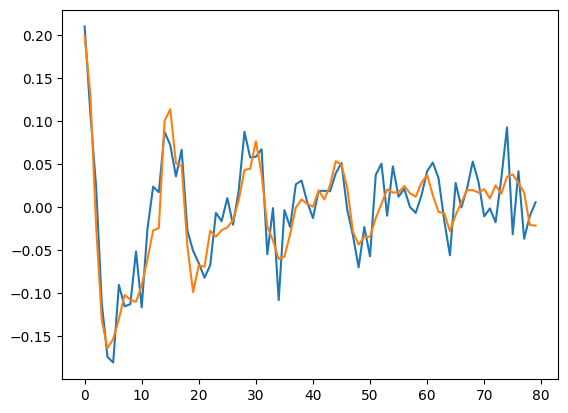

In [11]:
plt.plot(expectation_zne)
plt.plot(expectation_no_zne)
plt.show()

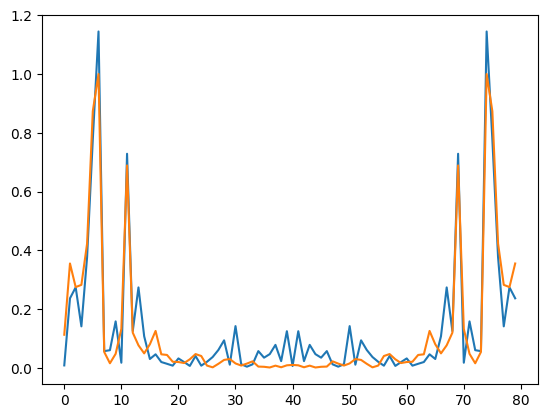

In [12]:
FT_zne = np.fft.fft(expectation_zne)/max(np.fft.fft(expectation_no_zne))
FT_no_zne = np.fft.fft(expectation_no_zne)/max(np.fft.fft(expectation_no_zne))
plt.plot(abs(FT_zne)**2)
plt.plot(abs(FT_no_zne)**2)
plt.show()